In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBClassifier
import warnings
from numpy import mean
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.utils import resample
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df.csv')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
df['y'] = df['y'].replace({'no':0,'yes':1})

In [4]:
df['y'].value_counts()/len(df)

0    0.9276
1    0.0724
Name: y, dtype: float64

Data is totally imbalanced. It will lead overfitting in model. I will create a new dataframe with upsampled minority class.

In [5]:
df_majority = df[df.y==0]
df_minority = df[df.y==1]


In [6]:
df_minority_new = resample(df_minority, 
                            replace=True,     
                            n_samples=30000,    
                            random_state=269) 
 
df2 = pd.concat([df_majority, df_minority_new])


In [7]:
df2.y.value_counts()

0    37104
1    30000
Name: y, dtype: int64

In [8]:
df2['y'].value_counts()/len(df2)

0    0.552933
1    0.447067
Name: y, dtype: float64

## Data Preprocessing

In [9]:
prds = df2.y.values
train = df2.drop(['y'],axis=1)

In [10]:
cat_cols = train.select_dtypes(include=('object'))
num_cols = train.select_dtypes(include=('int64'))

In [11]:
for column in num_cols:
    train[column] = MinMaxScaler().fit_transform(train[[column]])    

In [12]:
for column in cat_cols:
    train[column] = LabelEncoder().fit_transform(train[column])    
    
train = train.drop(['month','campaign','day'],axis=1)

In [14]:
train.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,duration
0,0.513158,4,1,2,0,0.092259,1,0,2,0.053070
1,0.328947,9,2,1,0,0.073067,1,0,2,0.030704


## Creating a Model

In [16]:
X_train,X_test,Y_train,Y_test = train_test_split(train,prds,test_size=0.25,random_state=254)

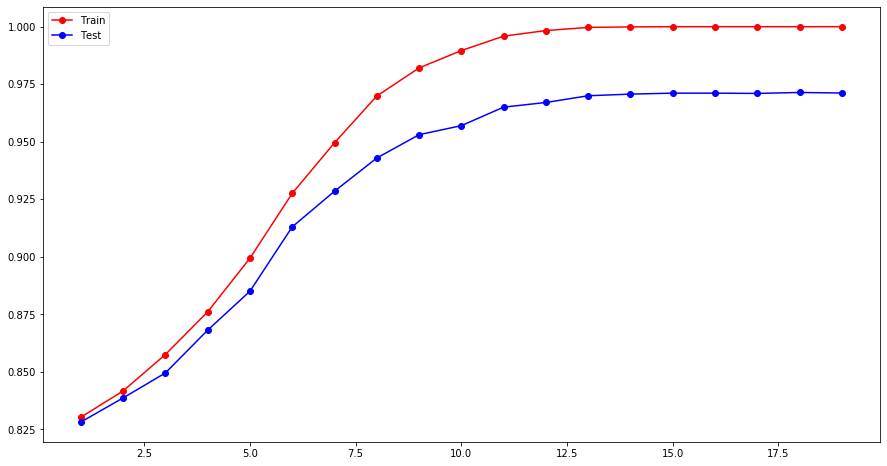

In [24]:
train_scores, test_scores = list(), list()
values = [i for i in range(1, 20)]
for i in values:
    model = XGBClassifier(max_depth=i)
    model.fit(X_train, Y_train)
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(Y_train, train_yhat)
    train_scores.append(train_acc)
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(Y_test, test_yhat)
    test_scores.append(test_acc)

plt.figure(figsize=(15,8))
plt.plot(values, train_scores, '-o', label='Train',color='red')
plt.plot(values, test_scores, '-o', label='Test',color='blue')
plt.legend()
plt.show()

## Hyperparmeter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

In [21]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        }
model = XGBClassifier()
xgb_grid = GridSearchCV(model,params,cv = 2, n_jobs = -1).fit(X_train,Y_train)

In [22]:
xgb_grid.best_params_

{'colsample_bytree': 1.0, 'gamma': 1, 'min_child_weight': 1, 'subsample': 0.6}

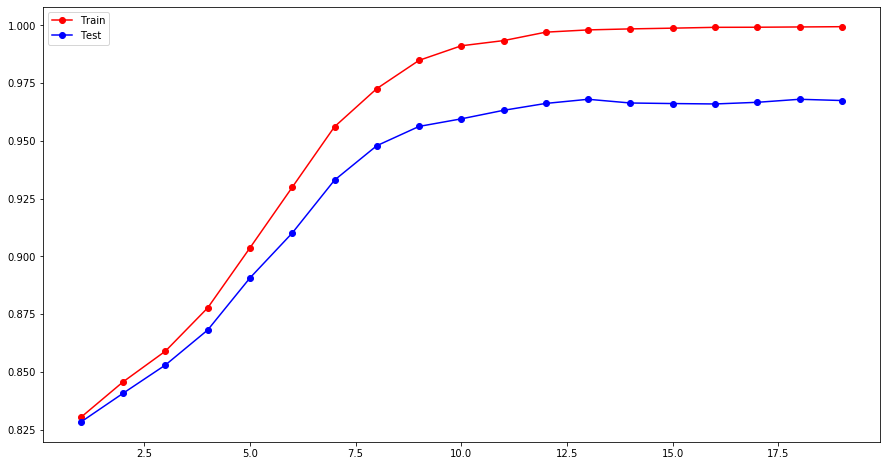

In [25]:
train_scores, test_scores = list(), list()
values = [i for i in range(1, 20)]
for i in values:
    model = XGBClassifier(max_depth=i,gamma=1,min_child_weight=1,subsample=0.6,colsample_bytree=1.0)
    model.fit(X_train, Y_train)
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(Y_train, train_yhat)
    train_scores.append(train_acc)
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(Y_test, test_yhat)
    test_scores.append(test_acc)

plt.figure(figsize=(15,8))
plt.plot(values, train_scores, '-o', label='Train',color='red')
plt.plot(values, test_scores, '-o', label='Test',color='blue')
plt.legend()
plt.show()

## K-FOLD Cross Validation

In [28]:
cv = KFold(n_splits=5, random_state=78, shuffle=True)
model = XGBClassifier(gamma=1,min_child_weight=1,subsample=0.6,colsample_bytree=1.0).fit(X_train, Y_train)
training_scores = cross_val_score(model, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
test_scores = cross_val_score(model, X_test, Y_test, scoring='accuracy', cv=cv, n_jobs=-1)

print('Average Training Accuracy: %.3f ' % (mean(training_scores)))
print('Average Test Accuracy: %.3f ' % (mean(test_scores)))

Average Training Accuracy: 0.908 
Average Test Accuracy: 0.881 


## Feature Importance

In [29]:
from xgboost import plot_importance

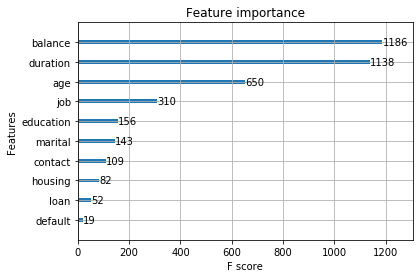

In [36]:
plot_importance(model)
plt.show();

Feature importance in XGBoost model is measured by F score. The most important feature in the model is balance.